<a href="https://colab.research.google.com/github/Floressek/LanguageProcessingLab/blob/main/Lab3/Szymon_Florek_NLP_EN_Lab7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis Using LSTM

> ZALECANE WLACZENIE NOTEBOOKA Z T4, wtedy czyszczenie danych ze spacy nie trwa 30 min a 10.

# Load The Data

In [3]:
from urllib.request import urlretrieve
import zipfile


amazon_mobile_reviews_url =  "https://eduds.blob.core.windows.net/nlp/Amazon_Unlocked_Mobile.csv.zip"
filename = "Amazon_Unlocked_Mobile.csv.zip"

urlretrieve(amazon_mobile_reviews_url, filename)

with zipfile.ZipFile("/content/Amazon_Unlocked_Mobile.csv.zip") as zfile:
  zfile.extractall()


In [4]:
import pandas as pd
df = pd.read_csv("/content/Amazon_Unlocked_Mobile.csv")


In [5]:
df


,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0
...,...,...,...,...,...,...
413835,Samsung Convoy U640 Phone for Verizon Wireless...,Samsung,79.95,5,another great deal great price,0.0
413836,Samsung Convoy U640 Phone for Verizon Wireless...,Samsung,79.95,3,Ok,0.0
413837,Samsung Convoy U640 Phone for Verizon Wireless...,Samsung,79.95,5,Passes every drop test onto porcelain tile!,0.0
413838,Samsung Convoy U640 Phone for Verizon Wireless...,Samsung,79.95,3,I returned it because it did not meet my needs...,0.0


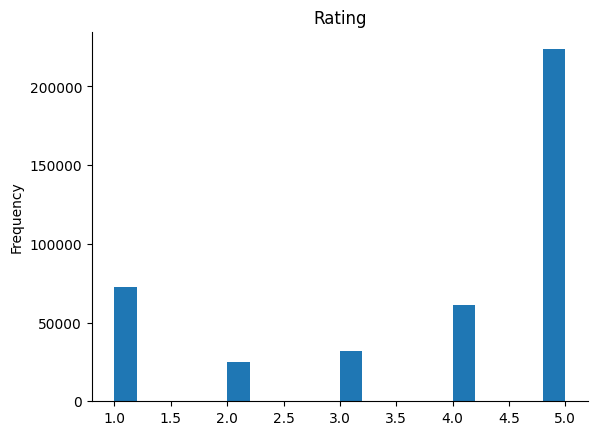

In [6]:
from matplotlib import pyplot as plt
df['Rating'].plot(kind='hist', bins=20, title='Rating')
plt.gca().spines[['top', 'right',]].set_visible(False)

***Hint***: work with sample drawn from original dataset. When you complete the code of the lab increase the size of the sample.

# Perform sentiment analysis with  nltk SentimentIntensityAnalyzer

Use library:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

Evaluate results:
1. accuracy
2. misclasification matrix

In [7]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
import pandas as pd
import nltk

nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

df['binary_rating'] = pd.cut(df['Rating'], bins=[0, 2, 5], labels=[0, 1])
df_clean = df.dropna(subset=["binary_rating"])

def get_vader_sent(text) -> int:
  if pd.isna(text):
    return np.nan
  score = sia.polarity_scores(str(text))["compound"]
  return 1 if score > 0.05 else 0

df_clean["vader_pred"] = df_clean["Reviews"].apply(get_vader_sent)
df_eval = df_clean.dropna(subset=["vader_pred"])

true_label = df_eval["binary_rating"].astype(int)
predictions = df_eval["vader_pred"].astype(int)

print(f"Accuracy: {accuracy_score(true_label, predictions):.3f}")
print(f"\nConfusion Matrix:\n{confusion_matrix(true_label, predictions)}")
print(f"\nClassification Report:\n{classification_report(true_label, predictions)}")





[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Accuracy: 0.791

Confusion Matrix:
[[ 71304  25755]
 [ 60807 255904]]

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.73      0.62     97059
           1       0.91      0.81      0.86    316711

    accuracy                           0.79    413770
   macro avg       0.72      0.77      0.74    413770
weighted avg       0.82      0.79      0.80    413770



# EDA and Data Preprocessing

1. Replace   null values in Brand Name with "Unknown" value
2. Find distribution of Rating (plot histogram)
3. Recode Rating  value into Sentiment (Rating >=3 - positive sentiment (1) , Rating  < 3 - negative (0))

# Text preprocessing
1. Change the words into its root words using spacy
2. Remove stopwords (optional)

In [9]:
!nvidia-smi
!pip install -U "spacy[cuda12x]" --prefer-binary
!python -m spacy download en_core_web_sm

Fri Nov 14 13:01:13 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [15]:
import spacy
import numpy as np
import pandas as pd

gpu_ok = spacy.require_gpu()
print("spaCy GPU available:", gpu_ok)

nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
print("spaCy pipeline:", nlp.pipe_names)

def spacy_preprocess_docs(texts, remove_stopwords: bool = True):
    docs = nlp.pipe(texts, batch_size=2048)
    result = []

    for doc in docs:
        tokens = []
        for token in doc:
            if token.is_space or token.is_punct:
                continue

            lemma = token.lemma_.lower()

            if remove_stopwords and token.is_stop:
                continue

            if not lemma.isalpha():
                continue

            tokens.append(lemma)

        result.append(" ".join(tokens) if tokens else np.nan)

    return result

texts = df["Reviews"].astype(str).fillna("")

df["review_clean"] = spacy_preprocess_docs(texts)

df_clean_text = df.dropna(subset=["review_clean"]).copy()
df_clean_text[["Reviews", "review_clean"]].head()
len(df_clean_text)


spaCy GPU available: True
spaCy pipeline: ['tok2vec', 'tagger', 'attribute_ruler', 'lemmatizer']


412160

In [17]:
df_clean_text.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,binary_rating,review_clean
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0,1,feel lucky find phone hard phone line upgrade ...
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0,1,nice phone nice grade pantach revue clean set ...
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0,1,pleased
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0,1,work good go slow good phone love
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0,1,great phone replace lost phone thing volume bu...


In [19]:
df_clean_text["binary_rating"] = pd.cut(
    df_clean_text["Rating"],
    bins = [0, 2, 5],
    labels = [0, 1]
)

df_clean_text = df_clean_text.dropna(subset=["binary_rating"]).copy()
df_clean_text["binary_rating"] = df_clean_text["binary_rating"].astype(int)

df_clean_text[["Reviews", "review_clean", "binary_rating"]].head()
#len(df_clean_text)

,Reviews,review_clean,binary_rating
0,I feel so LUCKY to have found this used (phone...,feel lucky find phone hard phone line upgrade ...,1
1,"nice phone, nice up grade from my pantach revu...",nice phone nice grade pantach revue clean set ...,1
2,Very pleased,pleased,1
3,It works good but it goes slow sometimes but i...,work good go slow good phone love,1
4,Great phone to replace my lost phone. The only...,great phone replace lost phone thing volume bu...,1


# Split Data into Train and Test

Test: 30% of randomly chosen  observations.
Random Seed: 10

In [22]:
from sklearn.model_selection import train_test_split

X_train_text, X_test_text, y_train, y_test = train_test_split(
    df_clean_text["review_clean"],
    df_clean_text["binary_rating"],
    test_size=0.3,
    random_state=10,
    stratify=df_clean_text["binary_rating"]
)

X_train_text.shape, X_test_text.shape

((288512,), (123648,))

# Tokenizing



Use Tokenizer to tokenize text

Replace value of oov_token is set to be ‘OOV’. That means any unknown words will be replaced by oov_token.

# Padding

Pad sequences to maximal length



In [28]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


vocab_size = 15000
oov_token = "OOV"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(df_clean_text["review_clean"])

X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_test_seq = tokenizer.texts_to_sequences(X_test_text)

print(X_train_text.iloc[0])
print(X_train_seq[0][:30])

love phone
[9, 2]


In [27]:
for idx in X_test_seq[0][:10]:
  print(idx, tokenizer.index_word.get(idx))

42 android
2 phone
65 little
133 slow
91 box
322 factory
355 reset
71 turn
73 lot
1536 widget


In [30]:
maxlen = 50

X_train = pad_sequences(X_train_seq, maxlen=maxlen, padding="post", truncating="post")
X_test = pad_sequences(X_test_seq, maxlen=maxlen, padding="post", truncating="post")

X_train.shape, X_test.shape

((288512, 50), (123648, 50))

# Model Creation


Model:

*   Embedding
*   LSTM (30 units)
*   Dense (2 layers, 2 x relu, last layer-  sigmoid)

Loss function: binary cross entropy , optimizer = 'adam'



Try to  build network like this:

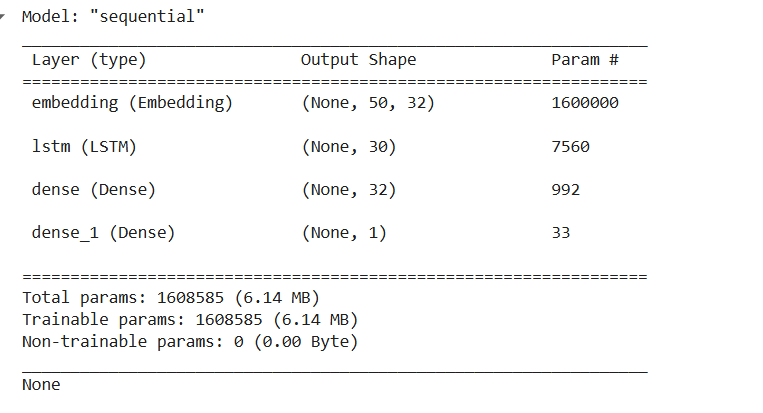

In [39]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
import tensorflow as tf
from tensorflow.keras import layers, models

embedding_dim = 32
lstm_units = 30

model = models.Sequential([
    layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=maxlen
    ),
    layers.LSTM(lstm_units),
    layers.Dense(32, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [40]:
batch_size = 256
epochs = 15

history = model.fit(
    X_train,
    y_train,
    validation_split=0.3,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
)

Epoch 1/15
789/789 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8152 - loss: 0.4310 - val_accuracy: 0.9001 - val_loss: 0.2395
Epoch 2/15
789/789 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9131 - loss: 0.2219 - val_accuracy: 0.9134 - val_loss: 0.2168
Epoch 3/15
789/789 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9235 - loss: 0.1959 - val_accuracy: 0.9109 - val_loss: 0.2187
Epoch 4/15
789/789 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9316 - loss: 0.1774 - val_accuracy: 0.9195 - val_loss: 0.2047
Epoch 5/15
789/789 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9368 - loss: 0.1628 - val_accuracy: 0.9175 - val_loss: 0.2084
Epoch 6/15
789/789 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9406 - loss: 0.1525 - val_accuracy: 0.9199 - val_loss: 0.2159
Epoch 7/15
789/789 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9434 - loss: 0.1445 - val_accuracy: 0.9200 - val_loss: 0.2144
Epoch 8/15
789/789 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.9465 - loss: 0.1355 - val_accuracy

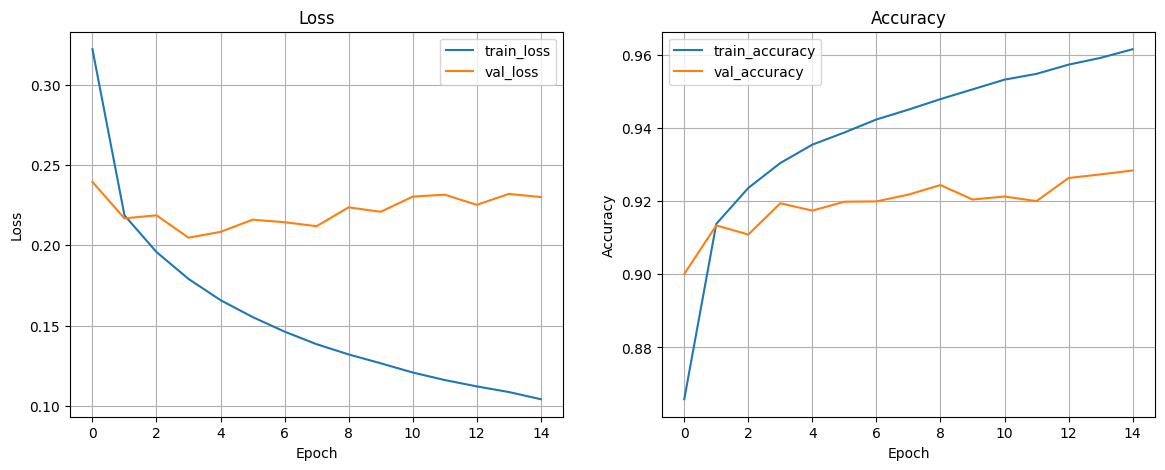

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Loss
ax[0].plot(history.history['loss'], label='train_loss')
ax[0].plot(history.history['val_loss'], label='val_loss')
ax[0].set_title('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].grid(True)

# Accuracy
ax[1].plot(history.history['accuracy'], label='train_accuracy')
ax[1].plot(history.history['val_accuracy'], label='val_accuracy')
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
ax[1].grid(True)

plt.show()

> Widoczny overfitting, wynika to z niezbalansowanych klas.

In [44]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 50, 32)         │       480,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30)             │         7,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │           992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,465,757 (5.59 MB)

 Trainable params: 488,585 (1.86 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 977,172 (3.73 MB)

# Model Training

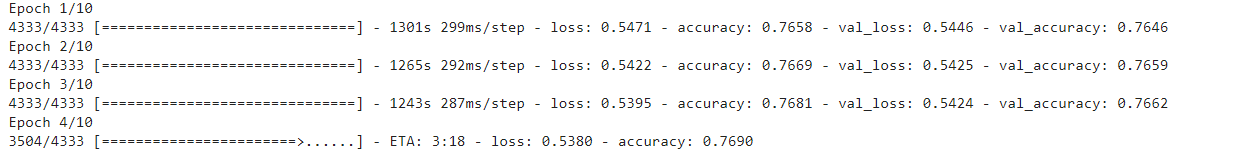

# Performance Metrics and Accuracy

Perform binary prediction on test data set

**Confusion Matrix**

In [45]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred_prob = model.predict(X_test).ravel()
y_pred = (y_pred_prob >= 0.5).astype(int)

print(f"Confusion matrix: \n {confusion_matrix(y_test, y_pred)}")
print(f"Classification report: \n {classification_report(y_test, y_pred)}")

3864/3864 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step
Confusion matrix: 
 [[24205  4865]
 [ 3893 90685]]
Classification report: 
               precision    recall  f1-score   support

           0       0.86      0.83      0.85     29070
           1       0.95      0.96      0.95     94578

    accuracy                           0.93    123648
   macro avg       0.91      0.90      0.90    123648
weighted avg       0.93      0.93      0.93    123648



**Accuracy Score**

In [46]:
from sklearn.metrics import accuracy_score
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")

Accuracy: 0.929


> Mimo overfittingu model radzi sobie dobrze ze zbiorem testowym. Zbior opini na amazonie jest zbiorem przewidywalnym, brak tu subtelnego sentymentu, wiec mimo ze model przeuczyl sie na danych treningowych to potem na bardzo podobnym zbiorze testowym jego accuracy jest 93%.